In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import re
import nltk
import math
import os
import matplotlib.pyplot as plt
import sklearn.metrics

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.linear_model import Perceptron

from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import pickle

%matplotlib inline


In [2]:
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

import tensorflow_datasets as tfds
import tensorflow as tf

Using TensorFlow backend.


## Load csv files

In [3]:
proteins = pd.read_csv('protein-SevenLocations-Feb12.csv')

proteins.head()

,name,sequence,location,label
0,tr|A0A0N4VT99|A0A0N4VT99_HAEPC,LLFVWLPQFIVRPHALLRFWMETDCQGNPPMYGDFEAQRHWMEITI...,0,ER
1,tr|A0A3P8RTP6|A0A3P8RTP6_AMPPE,MGRCVFLILAVLFSVTSSQFIPPYTEDCRTEMYPPKGPTYRGAVGW...,3,lysosome
2,sp|O89290|POL_HV193,MGARASVLSGGKLDAWEKIRLRPGGKKKYRLKHLVWASRELERFAL...,6,plasma_membrane
3,tr|S2JAV3|S2JAV3_MUCC1,MVKKQKKKQPITARVQPTEAKFKHSRVETARLIRKFHVLNKELAKC...,5,nucleus
4,sp|A5I7A5|UVRC_CLOBH,MFDLEYQLKNLPDKPGVYLMKNNLGEIIYVGKAKILKNRVRQYFQK...,2,cytoplasm


In [4]:
proteins.shape

(700483, 4)

In [5]:
# permute/scramble/shuffle rows of the dataframe
proteins = proteins.sample(frac=1)

In [6]:
proteins.location.value_counts()

5    178929
0    118331
4    109750
2     97116
1     75188
3     60911
6     60258
Name: location, dtype: int64

In [7]:
proteins.label.value_counts()

nucleus            178929
ER                 118331
mitochondria       109750
cytoplasm           97116
Golgi               75188
lysosome            60911
plasma_membrane     60258
Name: label, dtype: int64

In [8]:
# remove the duplicate protein sequences
proteins = proteins.drop_duplicates(subset='sequence', keep="first")

# remove nan from 'sequence' column
proteins = proteins[proteins['sequence'].notnull()]

proteins.shape

(700483, 4)

In [9]:
proteins.label.value_counts()

nucleus            178929
ER                 118331
mitochondria       109750
cytoplasm           97116
Golgi               75188
lysosome            60911
plasma_membrane     60258
Name: label, dtype: int64

## Transform the protein sequence data with CountVectorizer to get peptide frequency. Split the data into training & test sets.

In [10]:
# Peptide count is used for analysis
peptide_size = 3
vect = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(peptide_size,peptide_size))

In [11]:
X = vect.fit_transform(proteins.sequence)
y = proteins.location

In [12]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(560386, 8145) (560386,)
(140097, 8145) (140097,)


In [13]:
from keras.utils.np_utils import to_categorical

# one-hot encoding using keras' numpy-related utilities
n_classes = 7
print("Shape before one-hot encoding: ", y_train.shape)
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print("Shape after one-hot encoding: ", y_train.shape)
print("Shape after one-hot encoding: ", y_test.shape)

Shape before one-hot encoding:  (560386,)
Shape after one-hot encoding:  (560386, 7)
Shape after one-hot encoding:  (140097, 7)


In [14]:
#y_test.value_counts()

## Neural Network Version 1: Tripeptide Count Vector

In [15]:
# building a linear stack of layers with the sequential model
model = Sequential()
model.add(Dense(512, input_shape=(8145,)))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(7))
model.add(Activation('softmax'))

In [16]:
# 8. Compile model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
# 9. Fit model on training data
model.fit(X_train, y_train,batch_size=32,nb_epoch=3, verbose=1)

/Users/scottlew/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/3
560386/560386 [==============================] - 3178s 6ms/step - loss: 0.3887 - accuracy: 0.8795
Epoch 2/3
560386/560386 [==============================] - 2532s 5ms/step - loss: 0.2347 - accuracy: 0.9282
Epoch 3/3
560386/560386 [==============================] - 3351s 6ms/step - loss: 0.1796 - accuracy: 0.9448


In [18]:
# 10. Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=0)

print(score[1])

0.92021244764328


In [19]:
y_pred = model.predict(X_test)

In [20]:
y_pred_original=np.argmax(y_pred,axis=1)

y_pred_original

array([3, 0, 5, ..., 0, 3, 5])

In [21]:
y_test_original=np.argmax(y_test,axis=1)

y_test_original

array([3, 0, 5, ..., 0, 3, 5])

Text(0.5, 1.0, 'Confusion Matrix for Protein Location Neural Network Classifier')

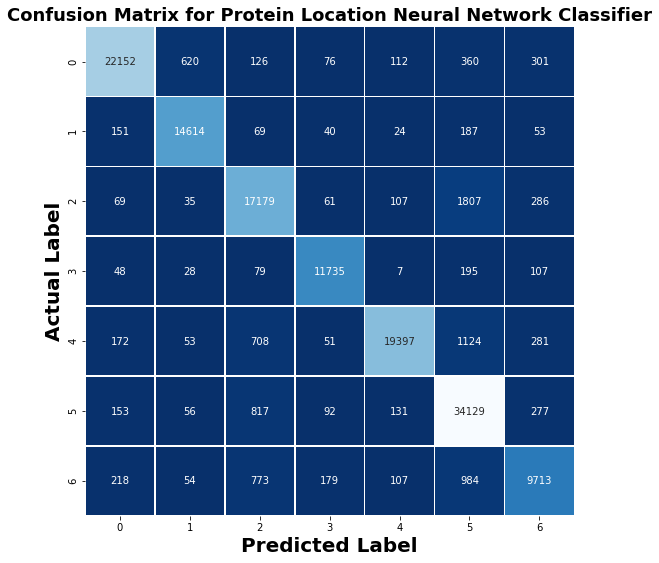

In [22]:
cm = confusion_matrix(y_test_original,y_pred_original)

# Confusion matrix 

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r',cbar=None);
plt.ylabel('Actual Label',weight = 'bold',size =20);
plt.xlabel('Predicted Label',weight = 'bold',size =20);

plt.title('Confusion Matrix for Protein Location Neural Network Classifier',weight = 'bold',size = 18)
#plt.savefig('XXXXX.png')

## Neural Network Model using tripeptide count vectors has ~92% accuracy on test data!